# Model Serving

## Celery
Celery is an asynchronous task queue/job queue based on distributed message passing.It is focused on real-time operation, but supports scheduling as well.

The execution units, called tasks, are executed concurrently on a single or more worker servers. Tasks can execute asynchronously (in the background) or synchronously (wait until ready).

Celery is used in production systems to process millions of tasks a day. In practice, jobs originate through a client. Celery then makes use of a **message broker** to distribute those tasks to one or many Celery workers, which perform the tasks, and produce results, that are then maintained in a **backend data store**.

A deep learning use case for Celery is in a model serving context, where a web-based API allows a deep learning model to be run on a data bundle. The web service then becomes the client, and the model prediction can be framed as a Celery task to be executed.

<div style="display:block;margin:auto;width:500px;">
    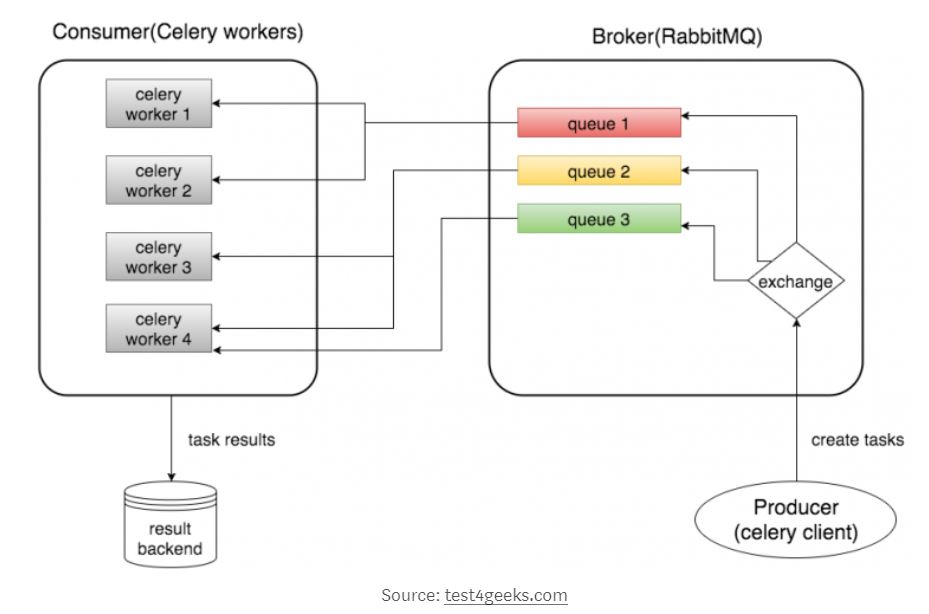
</div>
<div style="text-align:center;">**Example usage of Celery**</div>

### Install RabbitMQ
RabbitMQ will act as the broker for celery, managing the queue of tasks between the client and Celery workers.
```
sudo apt-get install rabbitmq-server
```

### Install Redis:
Redis, an in-memory data store, will act as the data store for the results of the Celery workers, allowing them to be accessed again by the client.
```
wget http://download.redis.io/redis-stable.tar.gz
tar xvzf redis-stable.tar.gz
cd redis-stable
make
make test
```
Then:
```
sudo apt-get install redis-server
```
Start the `redis-server` via:
```
sudo service redis-server start
```
Activate your virtual environment using the `venv` alias, then install Celery:
```
pip install --upgrade "celery[redis]"
```
Create a file called `celery_example.py` with the following contents:

In [3]:
from celery import Celery

app = Celery('tasks', backend='redis://localhost', broker='pyamqp://')

@app.task
def add(x, y):
    return x + y

You can start the Celery worker running with the command (in the command line):
```
celery -A celery_example worker --loglevel=info
```

Now, in Ipython or a Jupyter notebook, check the result of the following:

In [4]:
from celery_example import add

result = add.delay(1, 1)
result.get()

2

## Flask
Flask is a micro web framework written in Python that can be used to create web services and APIs.

Firstly, we'll create a basic Flask app to interface with our simple celery task. Create a python script called `flask_example.py` to interface with our previously-defined Celery task.

`add_server.py`

In [ ]:
from celery import Celery
import flask
from flask import Flask
from celery_example import add

def make_celery(app):
    # This is some celery magic to allow for a worker to access
    # to the Flask request context from within the celery worker.
    # See the docs at:
    # http://flask.pocoo.org/docs/0.12/patterns/celery/ for more.
    celery = Celery(app.import_name,
                    backend=app.config['CELERY_RESULT_BACKEND'],
                    broker=app.config['CELERY_BROKER_URL'])
    celery.conf.update(app.config)
    TaskBase = celery.Task

    class ContextTask(TaskBase):
        abstract = True

        def __call__(self, *args, **kwargs):
            with app.app_context():
                return TaskBase.__call__(self, *args, **kwargs)
    celery.Task = ContextTask
    return celery

# initialize the flask application and web server
app = Flask(__name__)
app.config.update(
    CELERY_BROKER_URL='pyamqp://',
    CELERY_RESULT_BACKEND='redis://localhost'
)


@app.route('/')
def add_greeting():
    return 'Hello, this is a simple service that adds two numbers.'


@app.route('/add_basic')
def add_basic():
    result = add.delay(1, 1)
    return flask.jsonify(result.get())


@app.route('/add', methods=['GET'])
def add_args():
    digit1 = int(flask.request.args.get('digit1'))
    digit2 = int(flask.request.args.get('digit2'))
    result = add.delay(digit1, digit2)
    return flask.jsonify(result.get())

# for debugging purposes start the flask testing server
if __name__ == '__main__':
    print('-> Starting Flask testing server for debugging (replace with prod)')
    port = 5000
    app.run(port=port)

You can run the web server on your local machine simply with:
```
python add_server.py
```

Navigating to [http://localhost:5000/](http://localhost:5000/) should display the text:
```
Hello, this is a simple service that adds two numbers.
```
We can retrieve the results of adding two arbitary numbers on our web service by passing the URL with a query string, for instance:

[http://localhost:5000/add?digit1=10&digit2=20](http://localhost:5000/add?digit1=10&digit2=20)

## Stress Testing

An important feature of a production service is the ability to handle high volumes of requests concurrently. We're going to test our simple addition service using the Python `multiprocessing` module:

```
stress_test.py
```

In [ ]:
import requests
import json
import argparse
import numpy as np
from tqdm import tqdm
from urllib.parse import urljoin
from time import time
from pathos.multiprocessing import Pool


def stress_test_worker(payloads, port):
    """
    Worker function for a single thread of the stress test.
    """
    baseurl = f'http://localhost:{port}'
    url = urljoin(baseurl, 'add')
    query_times = []
    successful_count = 0
    ntests = len(payloads)
    with tqdm(range(ntests), mininterval=2) as pbar:
        for payload in payloads:
            start = time()
            url_args = urljoin(url, payload)
            result = requests.request('GET', url_args)
            query_times.append(time()-start)
            if result.status_code == 200:
                successful_count += 1
            pbar.update()
    print('Worker finished. Successful request percentage: '
          f'{successful_count/ntests}')
    return query_times


def stress_test(nworkers=6, npayloads=10, port=5000):
    """
    Perform stress test on get_cluster_id with multiprocessing.
    """
    payload_list = [['?digit1={}&digit2={}'.format(
                        np.random.choice(range(10)),
                        np.random.choice(range(10)))]*npayloads
                    for num in range(nworkers)]
    with Pool(nworkers) as pool:
        time_list = pool.map(lambda x: stress_test_worker(payloads=x,
                                                          port=port),
                             payload_list)
    flat_times = [t for chunk in time_list for t in chunk]
    print(f'Average query time for {nworkers} workers and {npayloads} '
          f'requests per worker: {np.mean(flat_times):.4f} seconds')


def _parse_arguments():
    parser = argparse.ArgumentParser()
    parser.add_argument('--port', type=int, default=5000)
    parser.add_argument('--nworkers', type=int, default=6)
    parser.add_argument('--npayloads', type=int, default=1000)
    return parser.parse_args()


if __name__ == "__main__":
    args = _parse_arguments()
    nworkers = args.nworkers
    npayloads = args.npayloads
    port = args.port
    stress_test(nworkers, npayloads, port)

**Exercise: ** Create a web service to host the result of a feedforward neural network trained on MNIST. It should include:
1. Lazy loading of the Keras model object.
2. A predictive endpoint that accepts a `GET` request containing a `json` payload of the flattened input image array and returns the integer of the predicted class corresponding to this array.